# Libraries

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os as os
import pandas as pd
import seaborn as sns

import random
random.seed(0) # pick your seed

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Data

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  drive.mount('/content/gdrive', force_remount=True)
  dir = os.path.join('gdrive', 'My Drive', 'Eurostat', '02 - Data Science for Structured Data')
  data_dir = os.path.join(dir, 'data')
  os.system('cd "gdrive${dir}" && mkdir -p data')
else:
  data_dir = "." 

Mounted at /content/gdrive


In [ ]:
df_iris = pd.read_csv(os.path.join(data_dir, 'iris.csv'),
                      header=None,
                      names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
df_iris.sample(3)

,sepal_length,sepal_width,petal_length,petal_width,class
45,4.8,3.0,1.4,0.3,Iris-setosa
74,6.4,2.9,4.3,1.3,Iris-versicolor
41,4.5,2.3,1.3,0.3,Iris-setosa


In [ ]:
df_pima = pd.read_csv(os.path.join(data_dir, 'pima.csv'),
                      header=8,
                      names = ['preg', 'gluc', 'pres', 'skin' ,'insu', 'bmi', 'pedi', 'age', 'class'])
df_pima.sample(3)

,preg,gluc,pres,skin,insu,bmi,pedi,age,class
73,4,129,86,20,270,35.1,0.231,23,0
734,2,105,75,0,0,23.3,0.560,53,0
388,5,144,82,26,285,32.0,0.452,58,1


In [ ]:
df_wine = pd.read_csv(os.path.join(data_dir, 'wine.csv'), 
                      sep=';')
df_wine.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
39,7.3,0.45,0.36,5.9,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
758,8.1,0.87,0.00,2.2,0.084,10.0,31.0,0.99656,3.25,0.50,9.8,5
899,8.3,1.02,0.02,3.4,0.084,6.0,11.0,0.99892,3.48,0.49,11.0,3


In [ ]:
df_housing = pd.read_csv(os.path.join(data_dir, 'housing.csv'))
df_housing.sample(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
259,0.65665,20.0,3.97,0,0.647,6.842,100.0,2.0107,5,264,13.0,391.93,6.90,30.1
241,0.10612,30.0,4.93,0,0.428,6.095,65.1,6.3361,6,300,16.6,394.62,12.40,20.1
207,0.25199,0.0,10.59,0,0.489,5.783,72.7,4.3549,4,277,18.6,389.43,18.06,22.5


In [ ]:
df_happiness = pd.read_csv(os.path.join(data_dir, 'happiness.csv'))
df_happiness.sample(3)

,isced11,sex,age,geo,time,ACCSAT,COMSAT,FINSAT,GREENSAT,JOBSAT,LIFESAT,LIVENVSAT,MEANLIFE,RELSAT,TIMESAT
679,ED0-2,M,Y65-74,NO,2013,8.6,NaN,7.9,9.0,NaN,8.2,8.9,8.3,8.8,8.6
405,ED0-2,M,Y16-24,PT,2013,7.6,6.7,5.4,6.3,7.1,7.3,6.2,7.9,8.5,7.6
545,ED0-2,M,Y35-49,RS,2013,5.0,6.3,2.8,4.5,4.8,3.8,4.1,6.3,7.9,4.9


# Sampling

## Train- & Test-Sets
- Very fast
- Ideal for large datasets (millions of records)
- Ideal for slow-to-train algorithms

In [ ]:
from sklearn.model_selection import train_test_split

X = df_iris.copy()
y = X.pop('class')

test_size = 0.33
seed = 8

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

print('Train: ', X_train.shape, y_train.shape)
print('Test:  ', X_test.shape, y_test.shape)

Train:  (100, 4) (100,)
Test:   (50, 4) (50,)


In [ ]:
X_train.sample(5)

,sepal_length,sepal_width,petal_length,petal_width
102,7.1,3.0,5.9,2.1
13,4.3,3.0,1.1,0.1
130,7.4,2.8,6.1,1.9
138,6.0,3.0,4.8,1.8
110,6.5,3.2,5.1,2.0


In [ ]:
y_train.sample(5)

108     Iris-virginica
59     Iris-versicolor
53     Iris-versicolor
35         Iris-setosa
37         Iris-setosa
Name: class, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

model = SVR()
model.fit(X_train, y_train_enc)

preds = np.round(model.predict(X_test), 0)
correct = [int(pred_i) == y_i for pred_i, y_i in zip(preds, y_test_enc)]
print(f"Accuracy: {sum(correct)/len(correct)*100:.2f}%")

Accuracy: 98.00%


### Stratification

In [ ]:
df_iris['class'].value_counts()

Iris-virginica     50
Iris-versicolor    50
Iris-setosa        50
Name: class, dtype: int64

In [ ]:
df_pima['class'].value_counts()

0    500
1    268
Name: class, dtype: int64

In [ ]:
df_wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [ ]:
%%html
<iframe src="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html" width="1000" height="800"></iframe>

## K-fold Cross-Validation
- a more reliable estimate of the performance of the algorithm on new data
- **Gold standard** with _k = 3, 5, 10_

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

X = df_pima.copy()
y = X.pop('class')

kfold = KFold(n_splits=5, shuffle=True, random_state=8)
model = LogisticRegression(max_iter=1000)

results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 77.081% (1.650%)


In [ ]:
class_counts = sorted(y.value_counts().values)
print(f'The baseline is at: {class_counts[-1]/sum(class_counts)*100:.2f}%')

The baseline is at: 65.10%


In [ ]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)
    Evaluate a score by cross-validation
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like
        The data to fit. Can be for example a list, or an array.
    
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv`
        instance (e.g., :class:`GroupKFold`).
    
    scoring : string, callable or 

# Classification Metrics

### Classification Accuracy
- is the number of correct predictions made as a ratio of all predictions
made.
- suitable when there are an equal number of observations in each class
- suitable when all predictions and prediction errors are equally important

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

X = df_pima.copy()
y = X.pop('class')

kfold = KFold(n_splits=5, shuffle=True, random_state=8)
model = LogisticRegression(max_iter=1000)

results = cross_val_score(model,
                          X, 
                          y, 
                          cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 77.081% (1.650%)


### Logarithmic Loss
- **Likelihood function**: "How likely did the model think the actually observed set of outcomes was."
- Perfect score: 0
- Also called [Cross-entropy-loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss)

In [ ]:
%%html
<img src="https://miro.medium.com/max/1254/1*T8KWtAn8FkAcsg8RsjiZ6Q.png">

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

X = df_pima.copy()
y = X.pop('class')

kfold = KFold(n_splits=10, shuffle=True, random_state=8)
model = LogisticRegression(max_iter=1000)

scoring = 'neg_log_loss'
results = cross_val_score(model,
                          X, 
                          y,
                          cv=kfold,
                          scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))

Logloss: -0.488 (0.059)


### Area Under ROC Curve
* Represents a model's ability to discriminate between positive and negative
classes.
* Perfect score: 1
* Random model score: 0.5
* Trade-off between **sensitivity** and **specificity**
- **Sensitivity**: True positive rate, also called the **recall**. It is the ratio of instances from the positive class that were actually predicted correctly: TP / (TP + FN)
- **Specificity**: The true negative rate. Is the ratio of instances from the negative class that were actually predicted correctly: TN / (TN + FP)

In [ ]:
%%html
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Sensitivity_and_specificity_1.01.svg/1280px-Sensitivity_and_specificity_1.01.svg.png" width='400px'>

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

X = df_pima.copy()
y = X.pop('class')

kfold = KFold(n_splits=10, shuffle=True, random_state=8)
model = LogisticRegression(max_iter=1000)

scoring = 'roc_auc'
results = cross_val_score(model,
                          X,
                          y,
                          cv=kfold,
                          scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.827 (0.040)


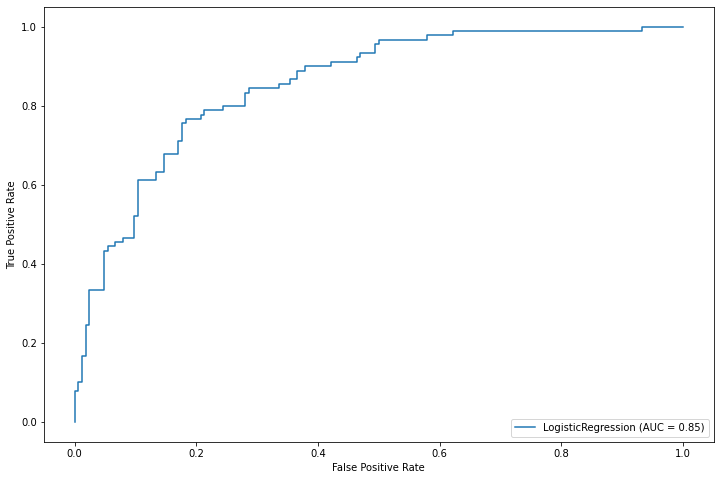

In [ ]:
from sklearn.metrics import plot_roc_curve

X = df_pima.copy()
y = X.pop('class')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

model = LogisticRegression(max_iter=1000)
model.fit(X_test, y_test)

fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curve(model, X_test, y_test, ax=ax)

## Confusion Matrix

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = df_pima.copy()
y = X.pop('class')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predicted = model.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[148  16]
 [ 37  53]]


[Text(0, 0, 'non-diabetic'), Text(0, 0, 'diabetic')]

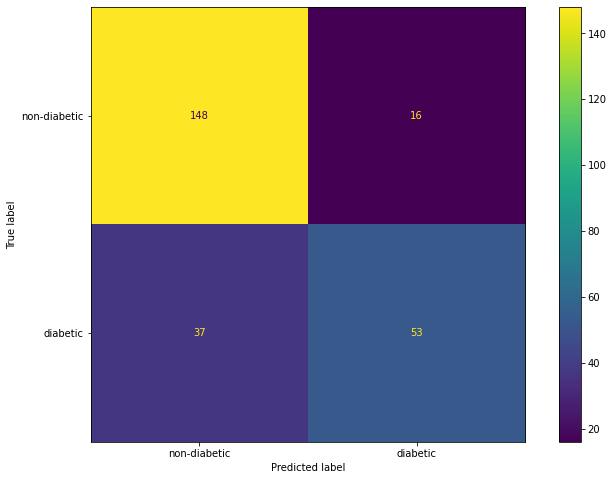

In [ ]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(model,
                      X_test, 
                      y_test,
                      values_format='d',
                      ax=ax)

ax.set_xticklabels(['non-diabetic', 'diabetic'])
ax.set_yticklabels(['non-diabetic', 'diabetic'])

In [ ]:
help(plot_confusion_matrix)

Help on function plot_confusion_matrix in module sklearn.metrics._plot.confusion_matrix:

plot_confusion_matrix(estimator, X, y_true, labels=None, sample_weight=None, normalize=None, display_labels=None, include_values=True, xticks_rotation='horizontal', values_format=None, cmap='viridis', ax=None)
    Plot Confusion Matrix.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    estimator : estimator instance
        Trained classifier.
    
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Input values.
    
    y : array-like of shape (n_samples,)
        Target values.
    
    labels : array-like of shape (n_classes,), default=None
        List of labels to index the matrix. This may be used to reorder or
        select a subset of labels. If `None` is given, those that appear at
        least once in `y_true` or `y_pred` are used in sorted order.
    
    sample_weight : array-like of shape (n_samples,), de

## Classification Report
- **F1 score** is the harmonic mean of **precision** and **recall (sensitivity)**

In [ ]:
%%html
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1280px-Precisionrecall.svg.png" width='400px'>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df_pima.copy()
y = X.pop('class')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predicted = model.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       164
           1       0.77      0.59      0.67        90

    accuracy                           0.79       254
   macro avg       0.78      0.75      0.76       254
weighted avg       0.79      0.79      0.78       254



In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

X = df_pima.copy()
y = X.pop('class')

kfold = KFold(n_splits=10, shuffle=True, random_state=8)
model = LogisticRegression(max_iter=1000)

scoring = 'f1_weighted'
results = cross_val_score(model,
                          X, 
                          y,
                          cv=kfold,
                          scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))

Logloss: 0.770 (0.039)
